In [136]:
from python_graphql_client import GraphqlClient
import pandas as pd
from datetime import datetime
import matplotlib

In [137]:
def client():
    return GraphqlClient(endpoint="https://api.studio.thegraph.com/query/19821/tornado-subgraph-mainnet/0.0.2")

def query(event, skip, timestamp):
    return """
    {
      """+event+"""(first: 1000, orderBy: timestamp, skip: """+ str(skip)+""",
      where: {timestamp_gt: """+ str(timestamp) +"""}) {
        id
        """+ ('from' if event =='deposits' else 'to') +"""
        index
        amount
        currency
        timestamp
      }
    }
"""

In [138]:
def getPoolEvents(event, debug=False):
    timestamp=0
    poolEvents=0
    
    while(True):
        skip=0
        poolEventsTs=0
        while(skip <= 5000):
            querys = query(event, skip, timestamp)
            try:
                tgdata_raw = client().execute(query=querys)['data'][event]
                if debug : print(skip, timestamp, len(tgdata_raw))
            except:
                print(client().execute(query=querys))
                break
            tgdata = pd.DataFrame.from_dict(tgdata_raw)
            if type(poolEventsTs) is int : poolEventsTs = tgdata 
            else : poolEventsTs = pd.concat([poolEventsTs,tgdata], ignore_index=True)

            if tgdata.shape[0] < 1000: break
            skip = skip + 1000
        if type(poolEvents) is int :  poolEvents = poolEventsTs 
        else :  poolEvents = pd.concat([poolEvents,poolEventsTs], ignore_index=True)

        if poolEventsTs.shape[0] < 6000: break
        timestamp = str(int(poolEventsTs['timestamp'].iloc[-1]) -1)

    return poolEvents

depositDf = getPoolEvents('deposits').drop_duplicates()
withdrawalDf = getPoolEvents('withdrawals').drop_duplicates()

generate entry number for withdrawals

In [139]:
withdrawalDf['pool'] = withdrawalDf['currency'] + withdrawalDf['amount']
withdrawalDfArr = []
for _,df in withdrawalDf.groupby('pool'):
    df.sort_values('timestamp',inplace=True)
    df.reset_index(drop=True,inplace=True)
    df['entry'] = df.index
    withdrawalDfArr.append(df)
withdrawalDf = pd.concat(withdrawalDfArr)
withdrawalDf.drop(['pool','index'],axis=1, inplace=True)

concat deposits and withdrawals

In [140]:
depositDf = depositDf.rename(columns={"from": "user", "index":"entry"})
withdrawalDf = withdrawalDf.rename(columns={"to": "user"})

depositDf['type'] = 'D'
withdrawalDf['type'] = 'W'
poolEventsDf = pd.concat(
    [withdrawalDf, depositDf[['id', 'user', 'entry','amount','currency','timestamp','type']]],
    ignore_index=True)

In [141]:
poolEventsDf.sort_values('timestamp',inplace=True, ignore_index=True)
poolEventsDf['time'] = pd.to_datetime(poolEventsDf['timestamp'], unit='s')
poolEventsDf.drop('timestamp',axis=1,inplace=True)
poolEventsDf.to_pickle('mainnet-pool-events.pkl')

In [142]:
poolEventsDf

,id,user,amount,currency,entry,type,time
0,0x0246beddfc8841c52dde875d6487c41c7c28b2a6ae56...,0x8589427373d6d84e98730d7795d8f6f8731fda16,0.1,eth,49,D,2019-12-16 19:21:10
1,0x0246beddfc8841c52dde875d6487c41c7c28b2a6ae56...,0x8589427373d6d84e98730d7795d8f6f8731fda16,0.1,eth,87,D,2019-12-16 19:21:10
2,0x0246beddfc8841c52dde875d6487c41c7c28b2a6ae56...,0x8589427373d6d84e98730d7795d8f6f8731fda16,0.1,eth,88,D,2019-12-16 19:21:10
3,0x0246beddfc8841c52dde875d6487c41c7c28b2a6ae56...,0x8589427373d6d84e98730d7795d8f6f8731fda16,0.1,eth,89,D,2019-12-16 19:21:10
4,0x0246beddfc8841c52dde875d6487c41c7c28b2a6ae56...,0x8589427373d6d84e98730d7795d8f6f8731fda16,0.1,eth,90,D,2019-12-16 19:21:10
...,...,...,...,...,...,...,...
263628,0x0ead02ccea9033a05c3692bd04fb747d974d6ee24155...,0x991af4a843a40fd0b7fb5af463c0f7b545243f27,1,eth,39633,W,2022-04-30 09:11:04
263629,0xb82abfe321651b630fd4ff6ff3939425022b6bd4a35c...,0xef992de961573f10cc3eae8e110a008d744f0023,100,eth,23200,W,2022-04-30 09:19:22
263630,0x4fa5aeb3e7cfdf3bcf6ba3cb03c68cf9d6e2625be404...,0x9e1e41985048c07a68a67f632f82799baaf903b1,100,eth,25041,D,2022-04-30 09:25:17
263631,0x366b8fae163f2f6fa8d6bf8a972a011575eee3e3582d...,0xa6a908008f6430888dff801de034ecabdf78cdf8,1,eth,39634,W,2022-04-30 09:28:57


## date grouping

In [17]:
poolEventsDf =  pd.read_pickle('mainnet-pool-events.pkl')
# poolEventsDf =  pd.read_json('mainnet-pool-events1.json')

In [18]:
poolEventsDf['date']= pd.to_datetime(poolEventsDf['timestamp'], unit='s').dt.date

In [26]:
def parseAmount(amt):
    amt= float(amt)
    if (amt>=1): return str(int(amt))
    else :return str(amt)    

dailyPoolEventsList = []
for date, df in poolEventsDf.groupby('date'):
    df['type'] = df['currency'] +'-'+ df['amount'].apply(parseAmount) +'-'+ df['type']
    dayEvents = df.groupby('type')['index'].count().rename(date)
    dailyPoolEventsList.append(dayEvents)
dailyPoolEvents = pd.concat(dailyPoolEventsList, axis=1).sort_values(by='type').fillna(0).transpose()
dailyPoolEvents 

type,cdai-5000-D,cdai-5000-W,cdai-50000-D,cdai-50000-W,cdai-500000-D,cdai-500000-W,cdai-5000000-D,cdai-5000000-W,dai-100-D,dai-100-W,...,usdt-100-D,usdt-100-W,usdt-1000-D,usdt-1000-W,wbtc-0.1-D,wbtc-0.1-W,wbtc-1-D,wbtc-1-W,wbtc-10-D,wbtc-10-W
2019-12-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0
2021-12-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2021-12-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
eventDf = dailyPoolEvents.cumsum()

In [28]:
eventDf

type,cdai-5000-D,cdai-5000-W,cdai-50000-D,cdai-50000-W,cdai-500000-D,cdai-500000-W,cdai-5000000-D,cdai-5000000-W,dai-100-D,dai-100-W,...,usdt-100-D,usdt-100-W,usdt-1000-D,usdt-1000-W,wbtc-0.1-D,wbtc-0.1-W,wbtc-1-D,wbtc-1-W,wbtc-10-D,wbtc-10-W
2019-12-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,5.0,3.0,118.0,115.0,87.0,83.0,114.0,110.0,191.0,150.0,...,250.0,196.0,667.0,643.0,133.0,104.0,994.0,963.0,1157.0,1145.0
2021-12-24,5.0,3.0,118.0,115.0,87.0,83.0,114.0,110.0,191.0,150.0,...,250.0,196.0,667.0,644.0,133.0,104.0,994.0,964.0,1157.0,1145.0
2021-12-25,5.0,3.0,118.0,115.0,87.0,83.0,114.0,110.0,191.0,150.0,...,250.0,196.0,667.0,644.0,133.0,104.0,994.0,964.0,1157.0,1145.0
2021-12-26,5.0,3.0,118.0,115.0,87.0,83.0,114.0,110.0,192.0,150.0,...,251.0,196.0,667.0,644.0,133.0,104.0,994.0,964.0,1157.0,1145.0


<IPython.core.display.Javascript object>


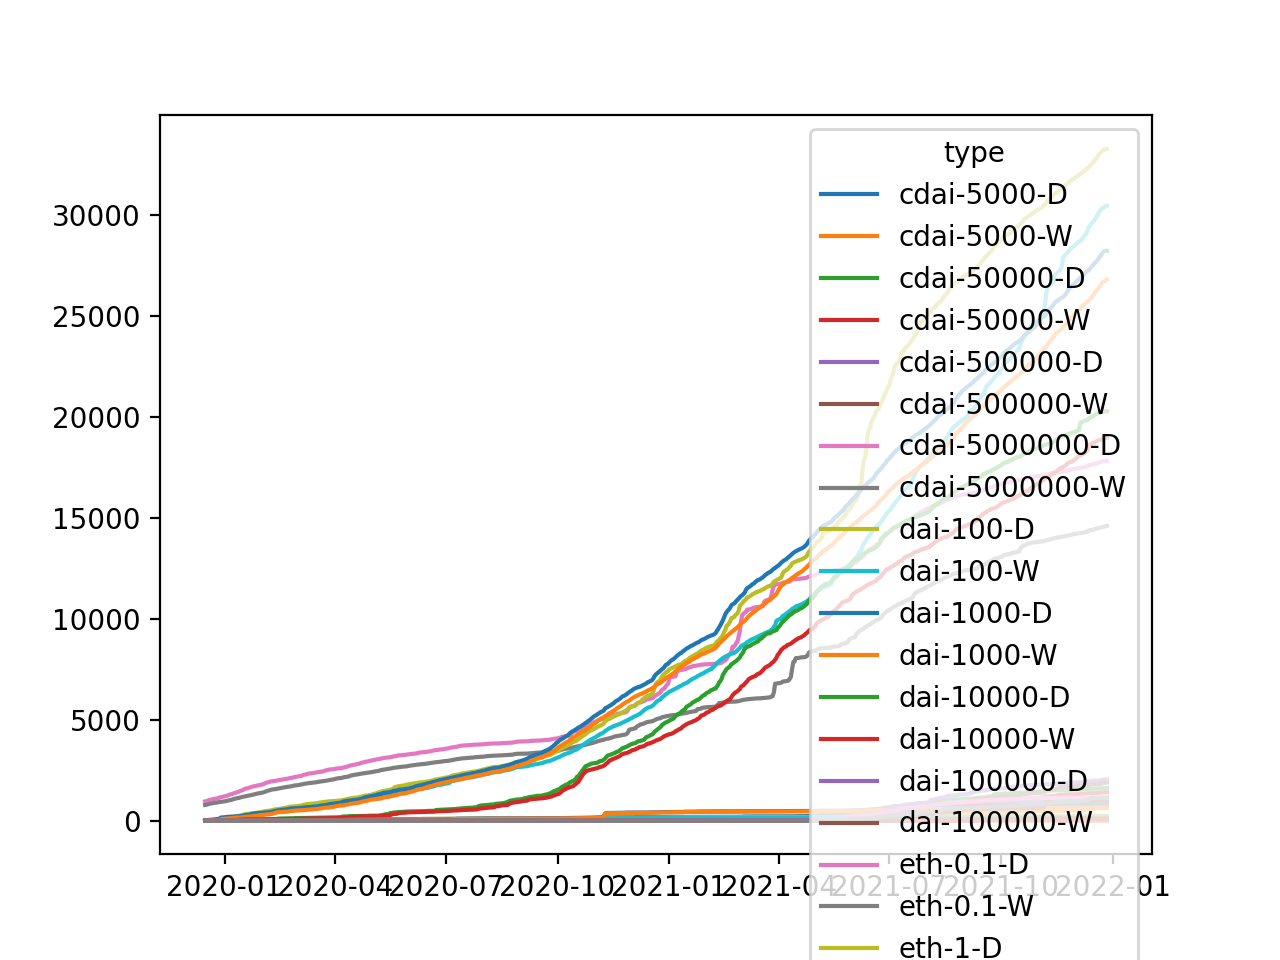

<AxesSubplot:>

In [29]:
%matplotlib notebook
eventDf.plot()

Level 1 (100$)

<IPython.core.display.Javascript object>


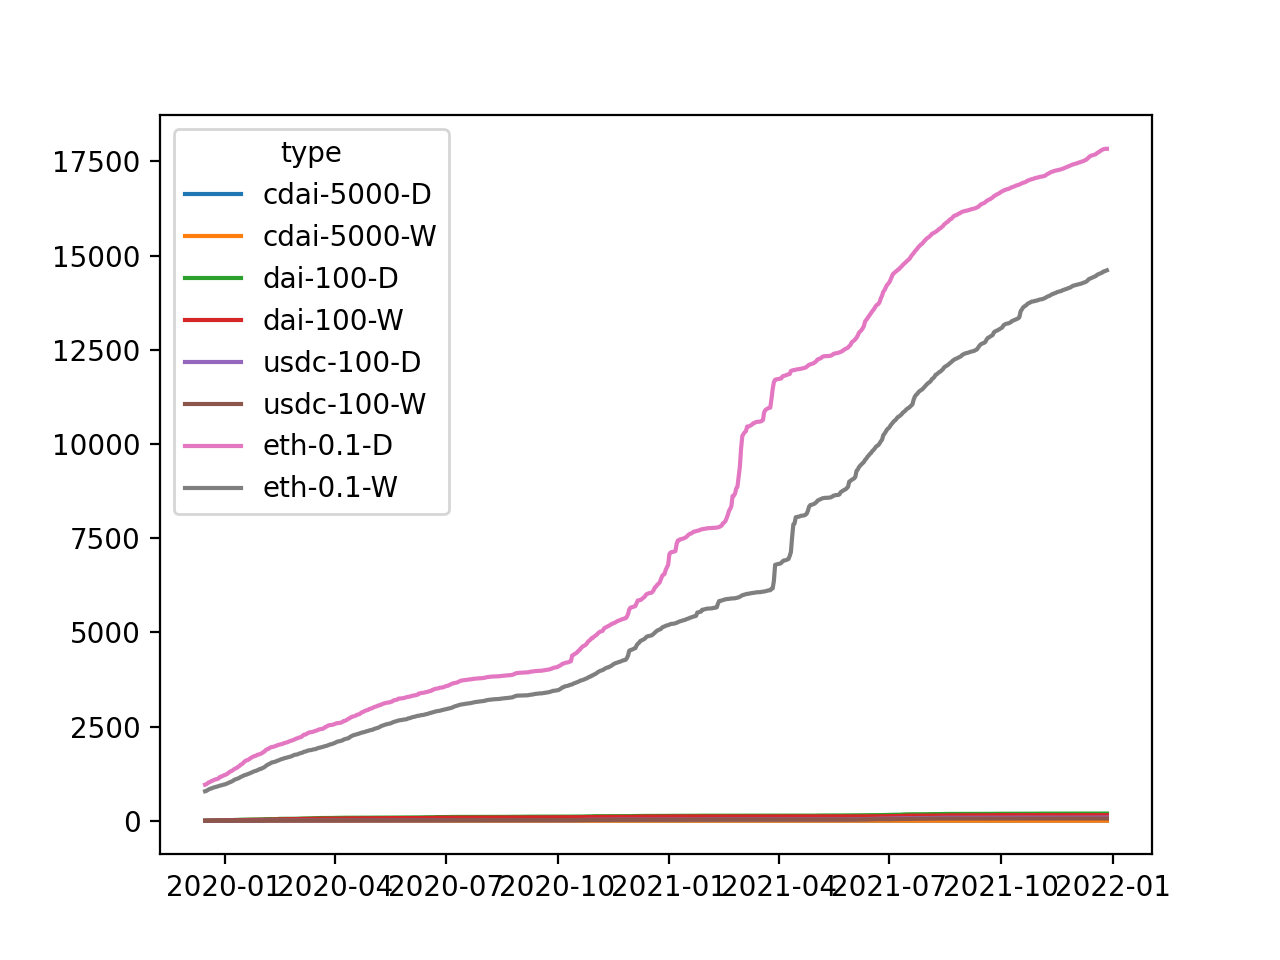

<AxesSubplot:>

In [30]:
%matplotlib notebook
eventDf[['cdai-5000-D',
         'cdai-5000-W',
         'dai-100-D',
         'dai-100-W',
         'usdc-100-D',
         'usdc-100-W',
         'eth-0.1-D',
         'eth-0.1-W'
        ]].plot()

<IPython.core.display.Javascript object>


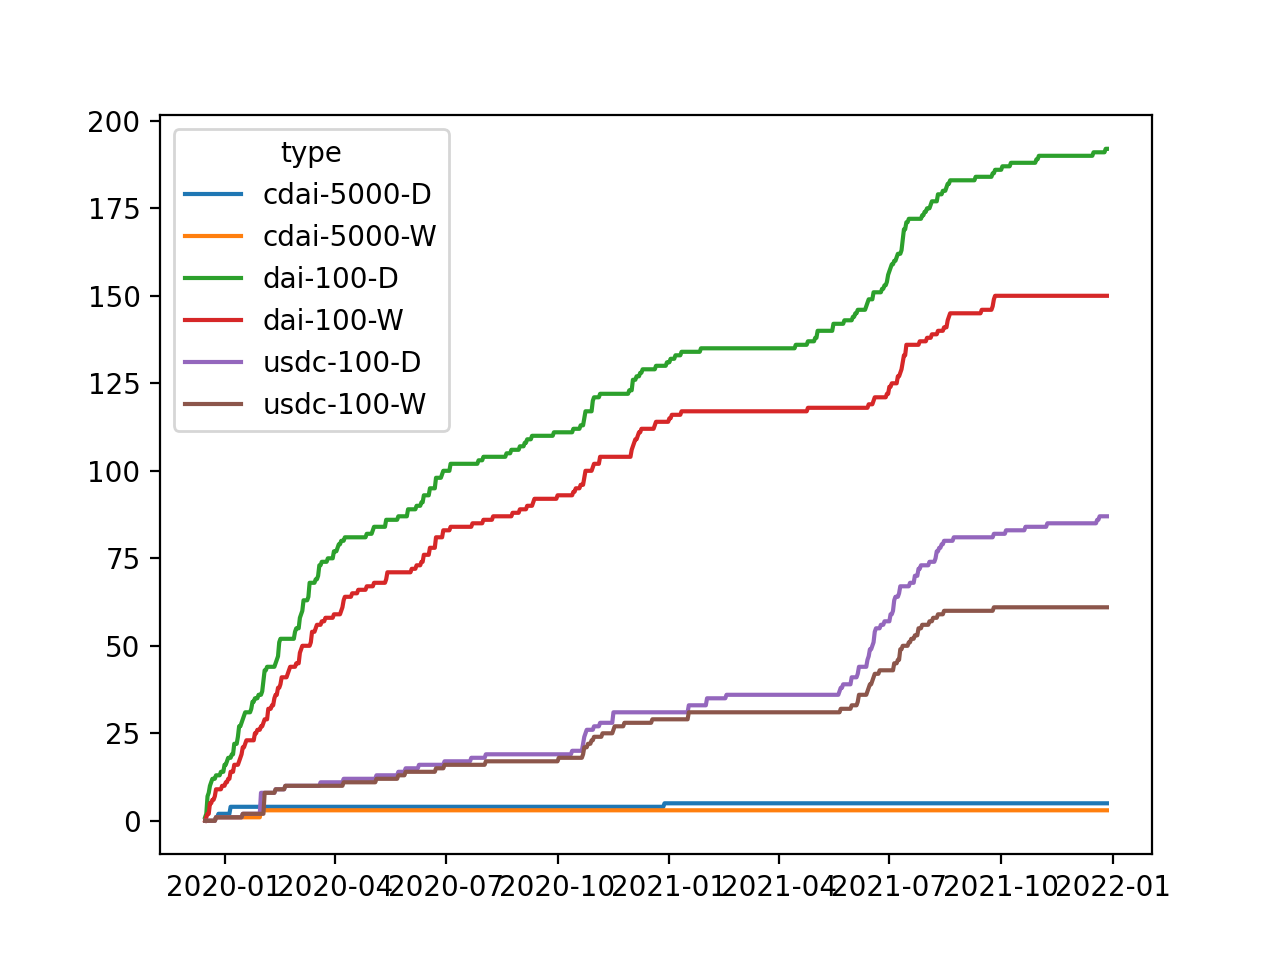

<AxesSubplot:>

In [31]:
eventDf[['cdai-5000-D',
         'cdai-5000-W',
         'dai-100-D',
         'dai-100-W',
         'usdc-100-D',
         'usdc-100-W'
        ]].plot()

level 2(1000$)

<IPython.core.display.Javascript object>


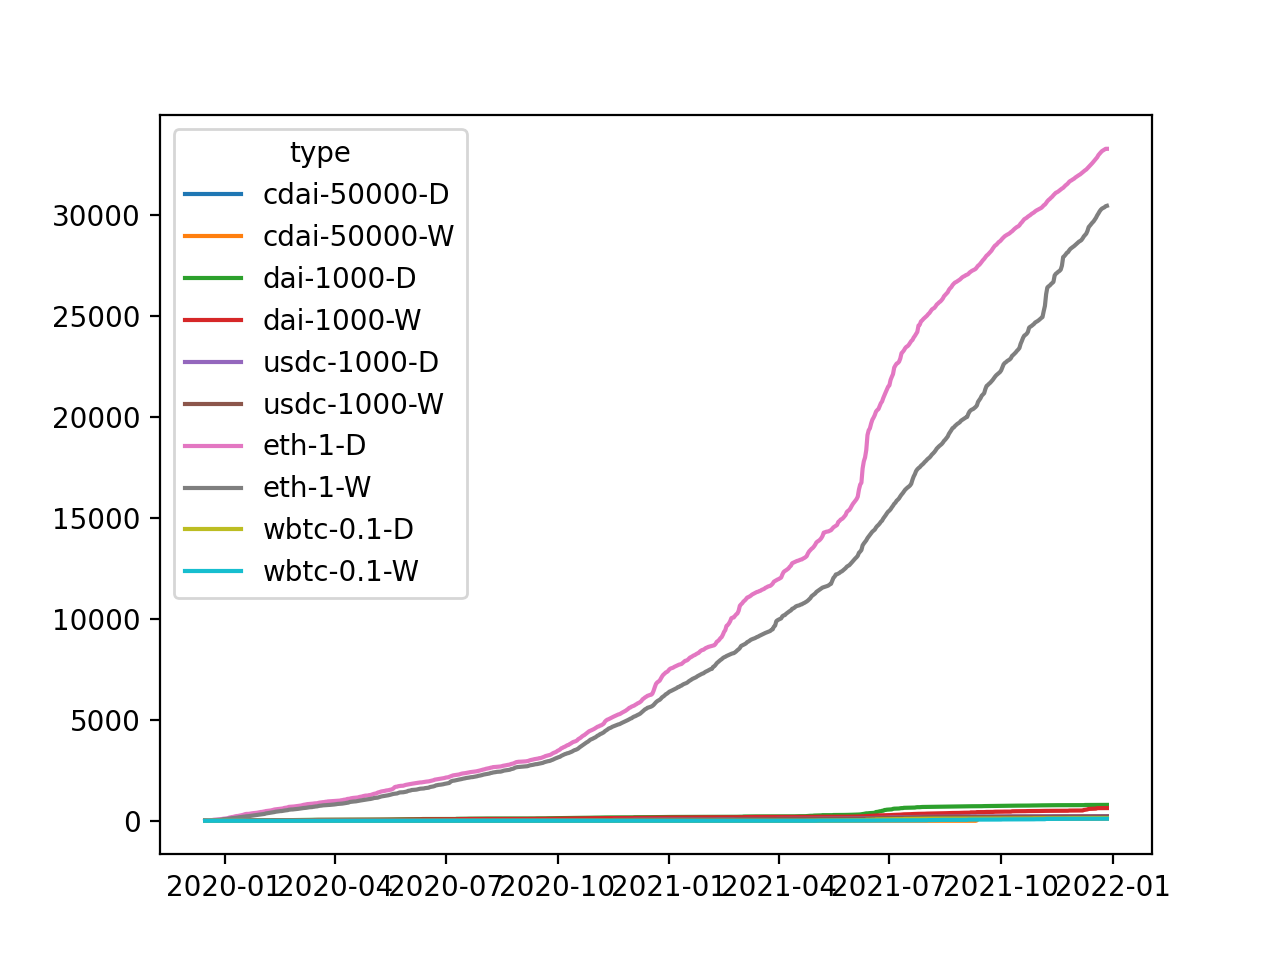

<AxesSubplot:>

In [33]:
eventDf[[
         'cdai-50000-D',
         'cdai-50000-W',
         'dai-1000-D',
         'dai-1000-W',
         'usdc-1000-D',
         'usdc-1000-W',
         'eth-1-D',
         'eth-1-W',
         'wbtc-0.1-D',
         'wbtc-0.1-W'
        ]].plot()

<IPython.core.display.Javascript object>


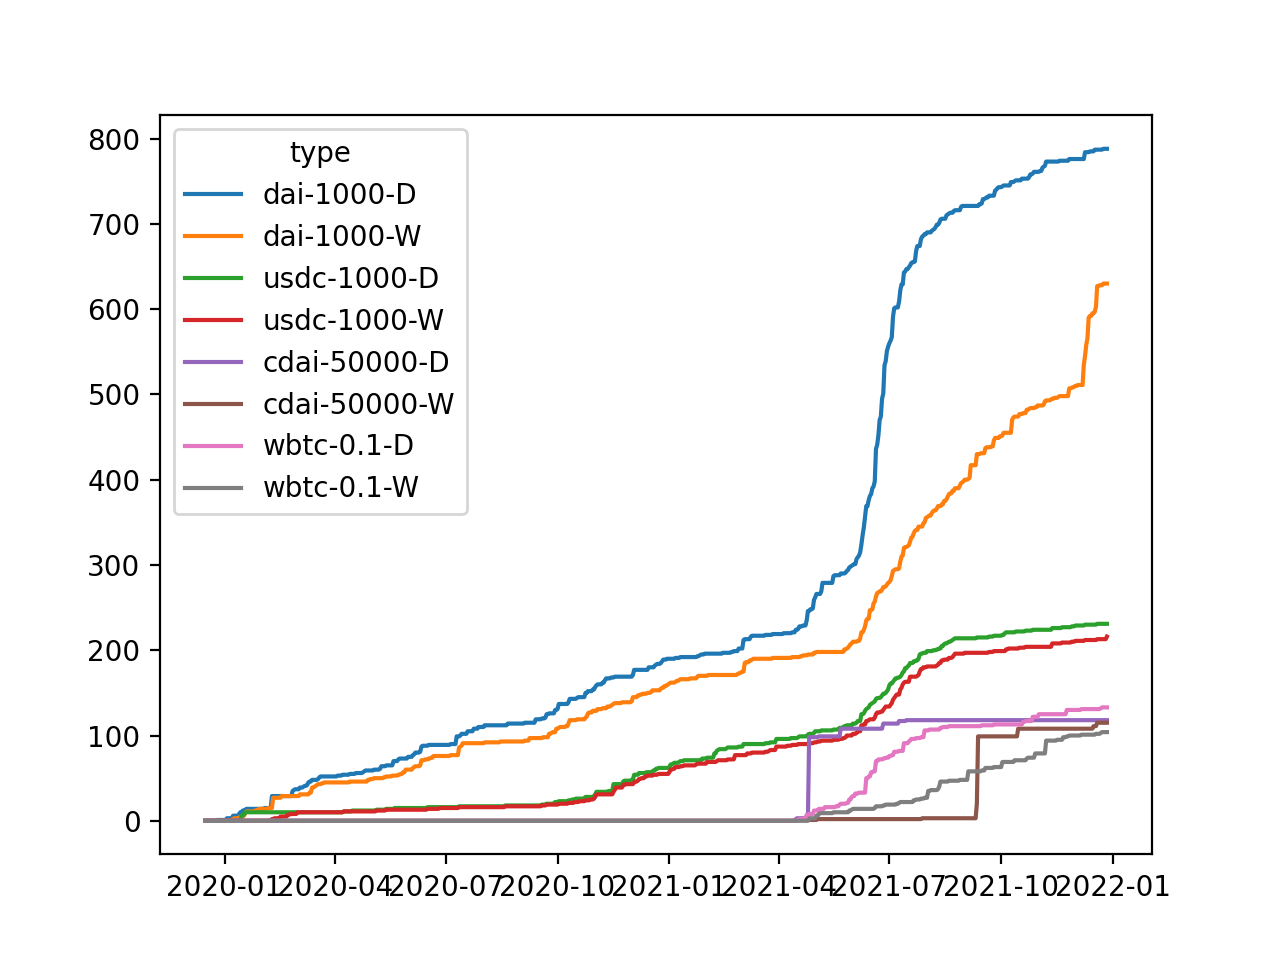

<AxesSubplot:>

In [34]:
eventDf[[
    'dai-1000-D',
    'dai-1000-W',
    'usdc-1000-D',
    'usdc-1000-W',
    'cdai-50000-D',
    'cdai-50000-W',
    'wbtc-0.1-D',
    'wbtc-0.1-W'
]].plot()

Level 10000$

<IPython.core.display.Javascript object>


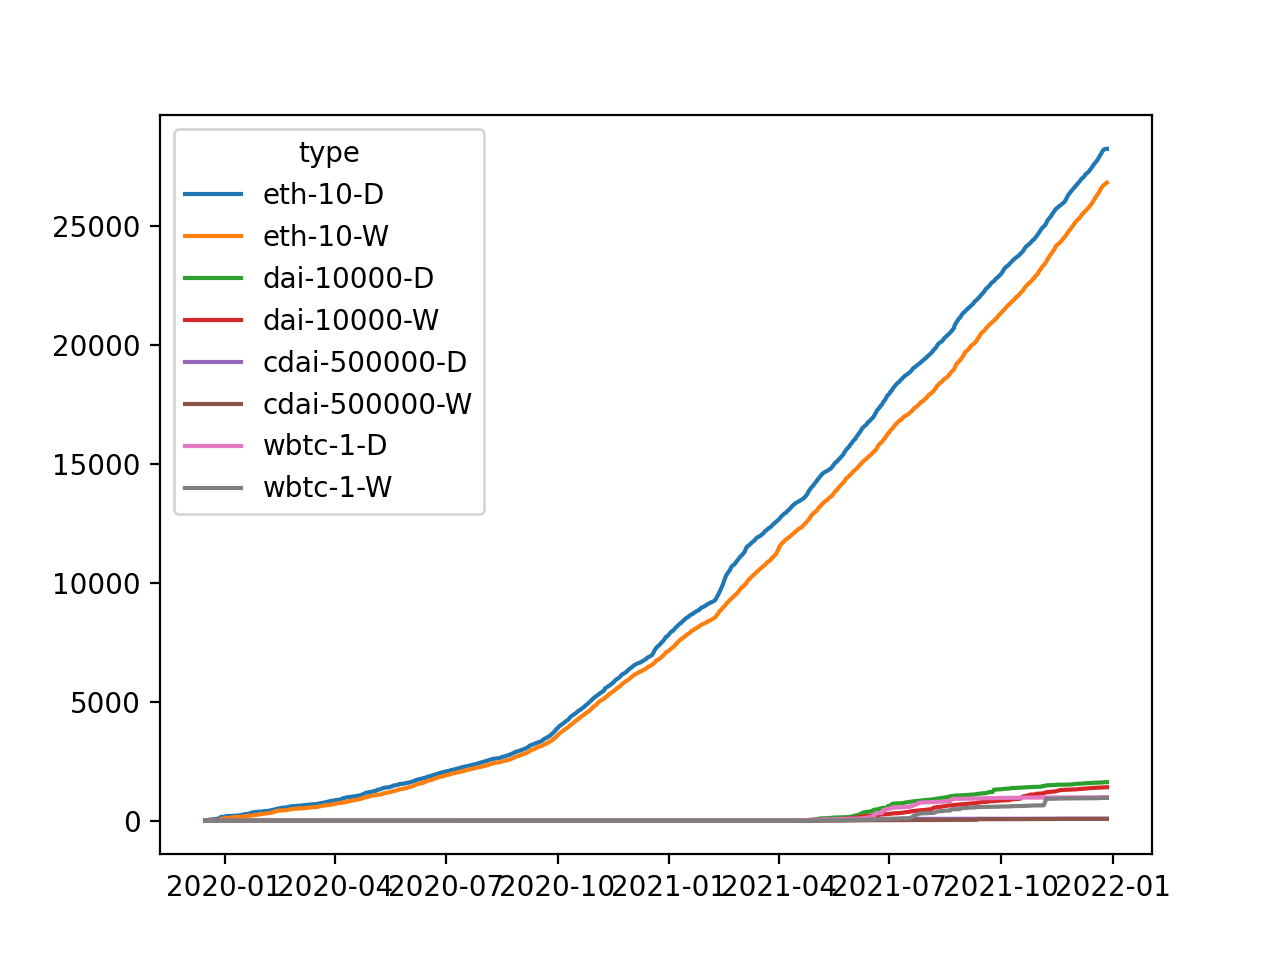

<AxesSubplot:>

In [35]:
eventDf[[
    'eth-10-D',
    'eth-10-W',
    'dai-10000-D',
    'dai-10000-W',
    'cdai-500000-D',
    'cdai-500000-W',
    'wbtc-1-D',
    'wbtc-1-W'
]].plot()

<IPython.core.display.Javascript object>


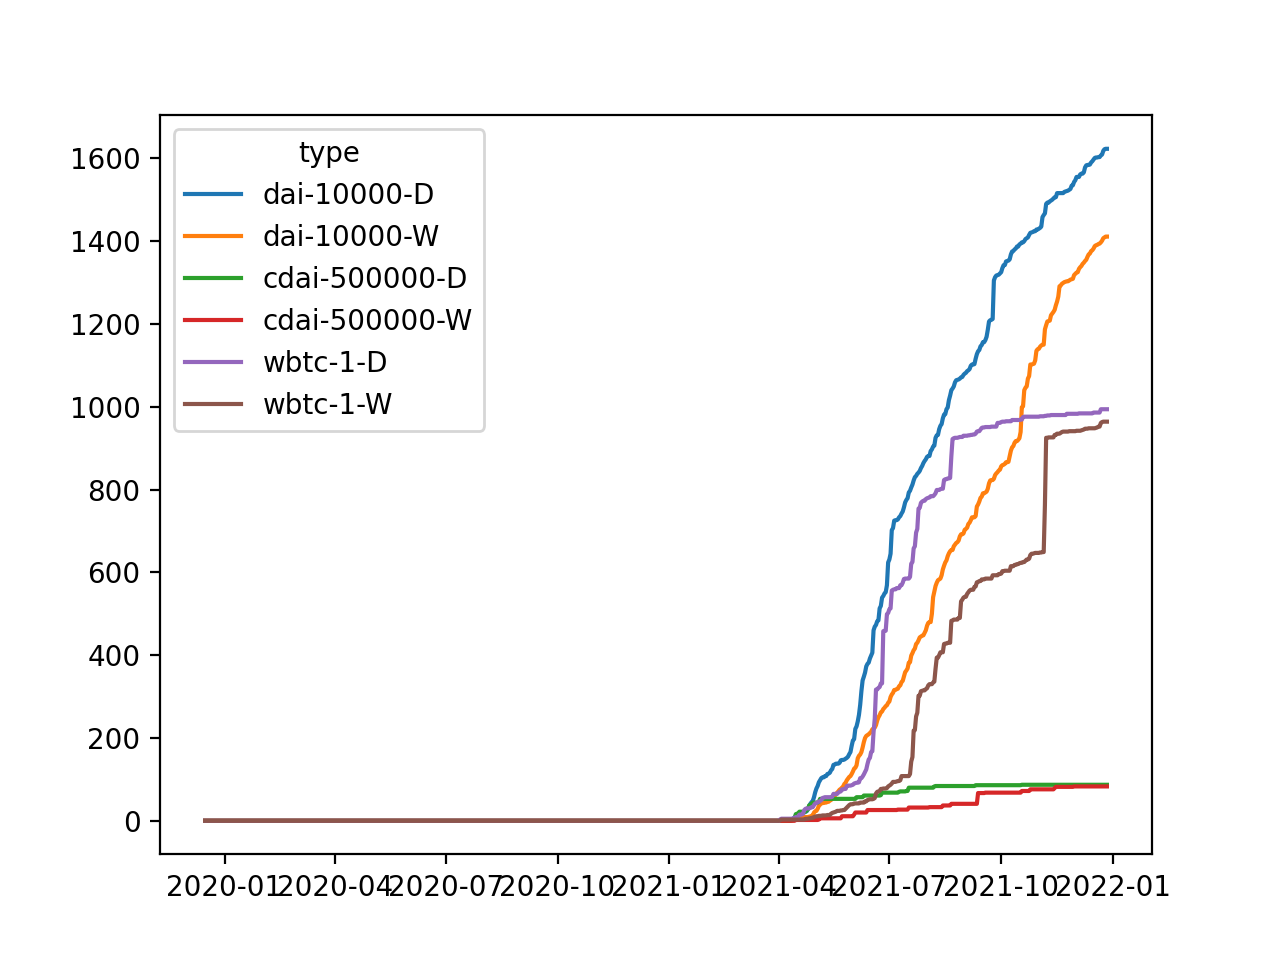

<AxesSubplot:>

In [38]:
eventDf[[
    'dai-10000-D',
    'dai-10000-W',
    'cdai-500000-D',
    'cdai-500000-W',
    'wbtc-1-D',
    'wbtc-1-W'
]].plot()

Level 100000$

<IPython.core.display.Javascript object>


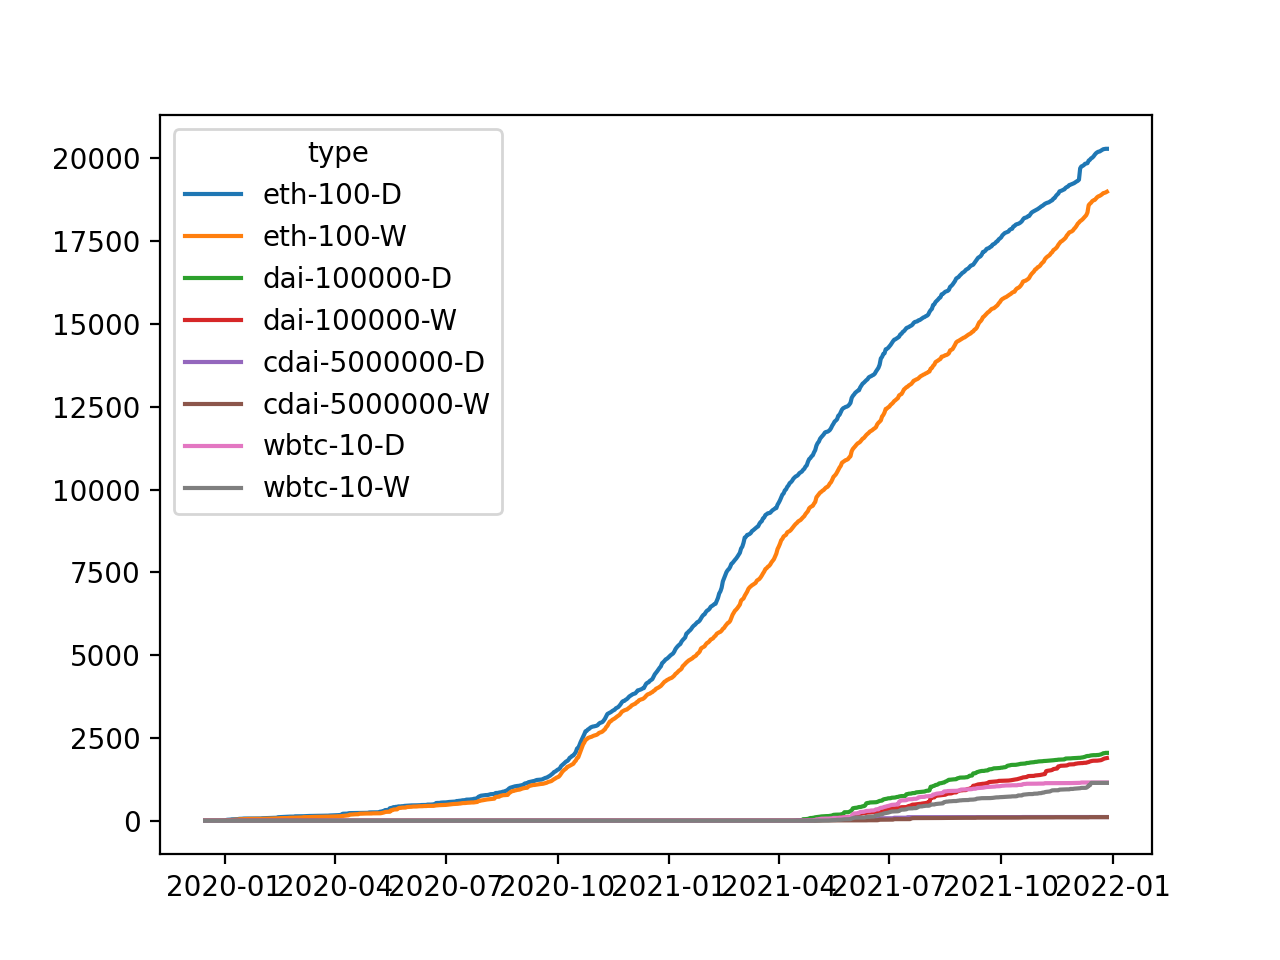

<AxesSubplot:>

In [41]:
eventDf[[
    'eth-100-D',
    'eth-100-W',
    'dai-100000-D',
    'dai-100000-W',
    'cdai-5000000-D',
    'cdai-5000000-W',
    'wbtc-10-D',
    'wbtc-10-W'
]].plot()

<IPython.core.display.Javascript object>


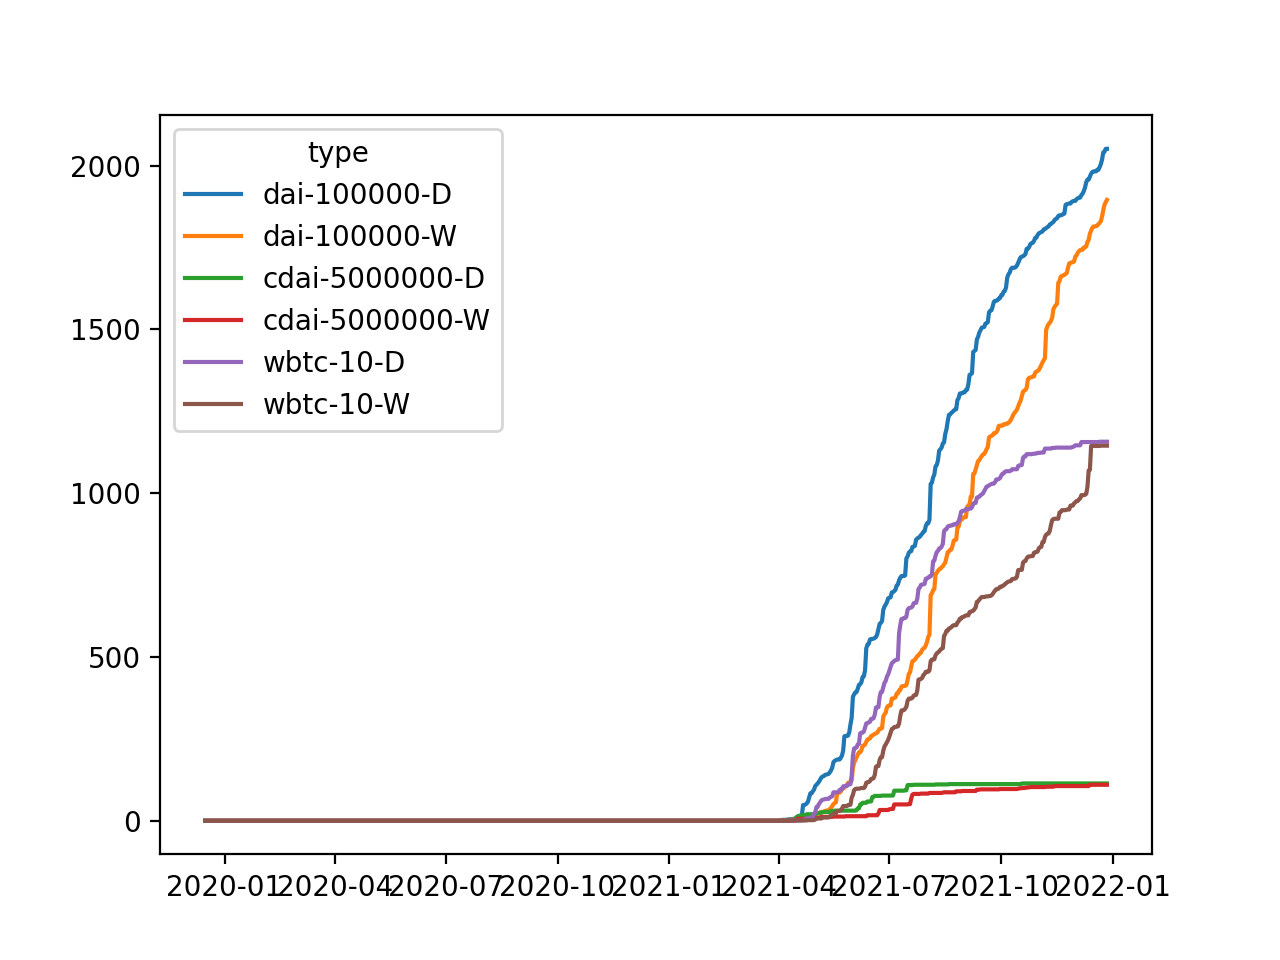

<AxesSubplot:>

In [143]:
eventDf[[
    'dai-100000-D',
    'dai-100000-W',
    'cdai-5000000-D',
    'cdai-5000000-W',
    'wbtc-10-D',
    'wbtc-10-W'
]].plot()